In [1]:
import sys

import seaborn as sns

sns.set()
# allows the import of scripts relative to project root
from scripts.parse_variation import plot_variation

## Finding diverging positions in a single spike protein across samples

To recap: 
    1. I took a few GISAID samples, translated them to proteins
        accoridng to open reading frames. 
    2. I then globally align all these sequences with a single 
        canonical protein. 
    3. Parsing the alignment file gives me a one-to-many sequence
        and sequences that are >90% identical are selected and written 
        in a separate file, which is then passed on to this code. 

#### And now, I do the following: 
        
This code will turn each sequence into a numpy array and then calculate the 
conservation score via Shannon Entropy and plot the standardized normalized score
on a seaborn line plot

#### The code itself
If you're looking for the code, my friend Viktor contributed by pulling the
code from the scripts folder. The code can be found here:
    https://github.com/nadzhou/CoVPeek/blob/master/scripts/parse_variation.py

{'N', 'K', 'W', 'R', 'L', 'A', 'T', 'G', 'P', 'H', 'V', 'C', 'Q', 'Y', 'D', 'S', 'I', 'E', 'F', 'M'}


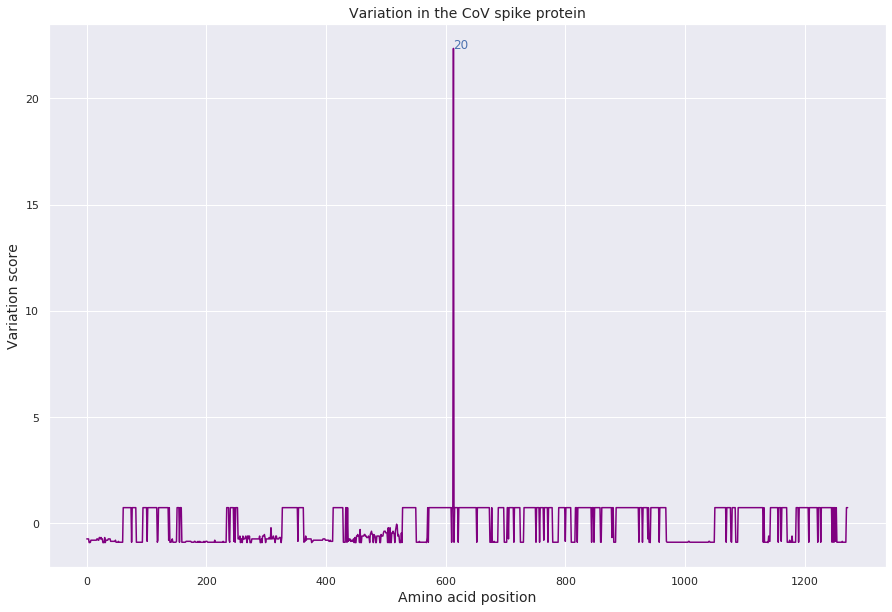

In [2]:
# Load the aligned FASTA file
aligned_path = "gisaid_results/mafft_aligned.fasta"
aa_count = plot_variation(aligned_path)



## Cross-check with another sample
The plot here shows that for this given GISAID dataset (about 16k sequences in total), the divergence at the 613th position shows the highest amount of divergence. In fact, we can see that the position can have all the possible amino acids in that position. 
I've done this for another GISAID sample (a comparatively smaller one) that shows that this position does indeed show maximum divergence. 

{'N', 'K', 'W', 'R', 'L', 'A', 'T', 'G', 'P', 'H', 'V', 'C', 'Q', 'Y', 'D', 'S', 'I', 'E', 'F', 'M'}


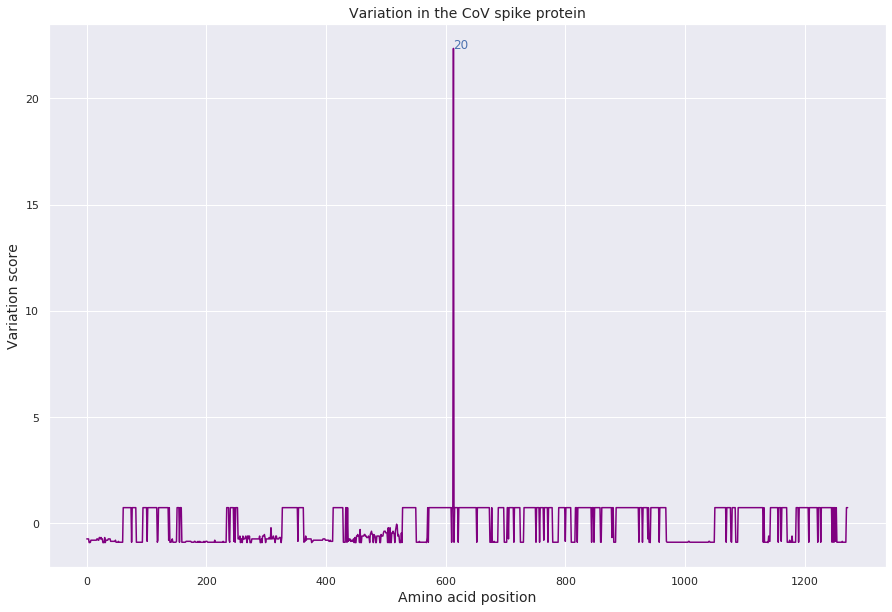

In [4]:
aligned_path2 = "/home/nadzhou/SEQs/id_MAFFT0.fasta"
# we use the previous dataset, since data is not shared, fix later
aa_count2 = plot_variation(aligned_path)

## Validation
Seems like this 614th position (I start with 0, so mine is 613) is not new. This has already been reported in the following Biorxiv paper: 
        https://www.biorxiv.org/content/10.1101/2020.04.29.069054v1.full.pdf
    
    
 From the article's abstract: 
 
  "Here we describe a three-stage data pipeline (analysis of daily GISAID data, structural modeling 
  of sites of interest, and experimental evaluation) and the identification of several sites of 
  positive selection, including one (D614G) thatmay have originated either in China or Europe, but begin 
  to spread rapidly first in Europe, and then in otherparts of the world,and which is now the dominant 
  pandemic form in many countries."

## Contribution
### The 613th psoition doesn't just show substition between 2 amino acids, but multiple. 
Here however, I present the result that this 614th position doesn't only contain aspartic acid / glutamine substitution, but this position can be substituted by ALL amino acids. 

### There's a strong bias against Histidine, Methionine and Tryptophan at the 613th position.
As can be seen in the subsequent graph, there's a strong bias against the three amino acids. This seems to be an important result coming from the given samples from across the globe. 

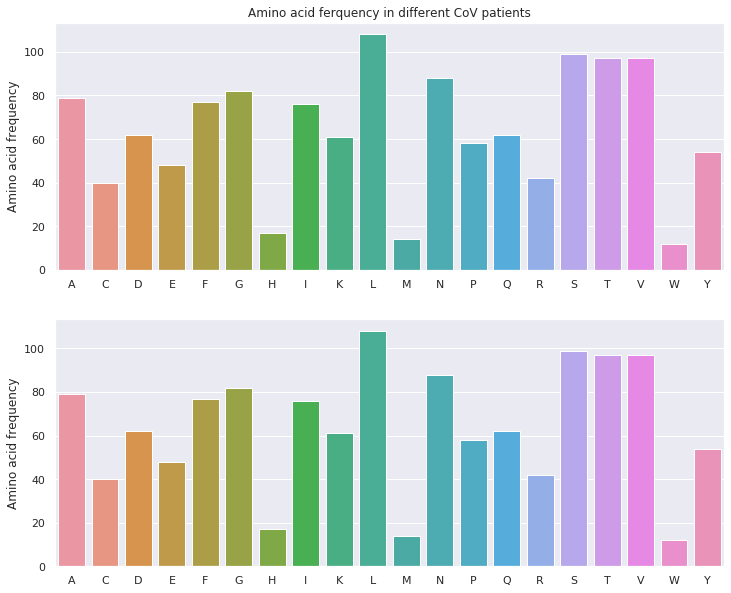

In [5]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

sns.countplot(aa_count, ax=ax1)
ax1.set_ylabel("Amino acid frequency")
ax1.set_title("Amino acid ferquency in different CoV patients")

sns.countplot(aa_count2, ax=ax2)
ax2.set_ylabel("Amino acid frequency")
fig.show()